<h3>Imports</h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

<h3>Conjunto de dados</h3>

In [2]:
car_evaluation = fetch_openml(name="car", version=3, parser='auto')
df = pd.DataFrame(data=car_evaluation.data, columns=car_evaluation.feature_names)
df['target'] = car_evaluation.target

print(df.head())

  buying  maint doors persons lug_boot safety target
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


In [3]:
# Codificação one-hot
df_encoded = pd.get_dummies(df.drop('target', axis=1))

# Separar variáveis independentes e variável dependente
X = df_encoded
y = df['target']

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
predictions_rf = rf_classifier.predict(X_test)

# Avaliar o desempenho do modelo
accuracy_rf = accuracy_score(y_test, predictions_rf)
print(f'Acurácia do Random Forest: {accuracy_rf:.4f}%')

# Relatório de Classificação
print('\nRelatório de Classificação:')
print(classification_report(y_test, predictions_rf))

# Matriz de Confusão
conf_matrix_rf = confusion_matrix(y_test, predictions_rf)
print('\nMatriz de Confusão:')
print(conf_matrix_rf)

Acurácia do Random Forest: 0.9538%

Relatório de Classificação:
              precision    recall  f1-score   support

         acc       0.97      0.84      0.90        83
        good       0.59      0.91      0.71        11
       unacc       0.98      1.00      0.99       235
       vgood       0.83      0.88      0.86        17

    accuracy                           0.95       346
   macro avg       0.84      0.91      0.87       346
weighted avg       0.96      0.95      0.95       346


Matriz de Confusão:
[[ 70   7   4   2]
 [  0  10   0   1]
 [  0   0 235   0]
 [  2   0   0  15]]


<h2>Entedimento dos dados - exploração</h2>

<h3>Verifica se há valores ausentes</h3>

In [4]:
print("Valores Ausentes: ")
print(df.isnull().sum())

Valores Ausentes: 
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
target      0
dtype: int64


<p>Não há dados faltantes</p>

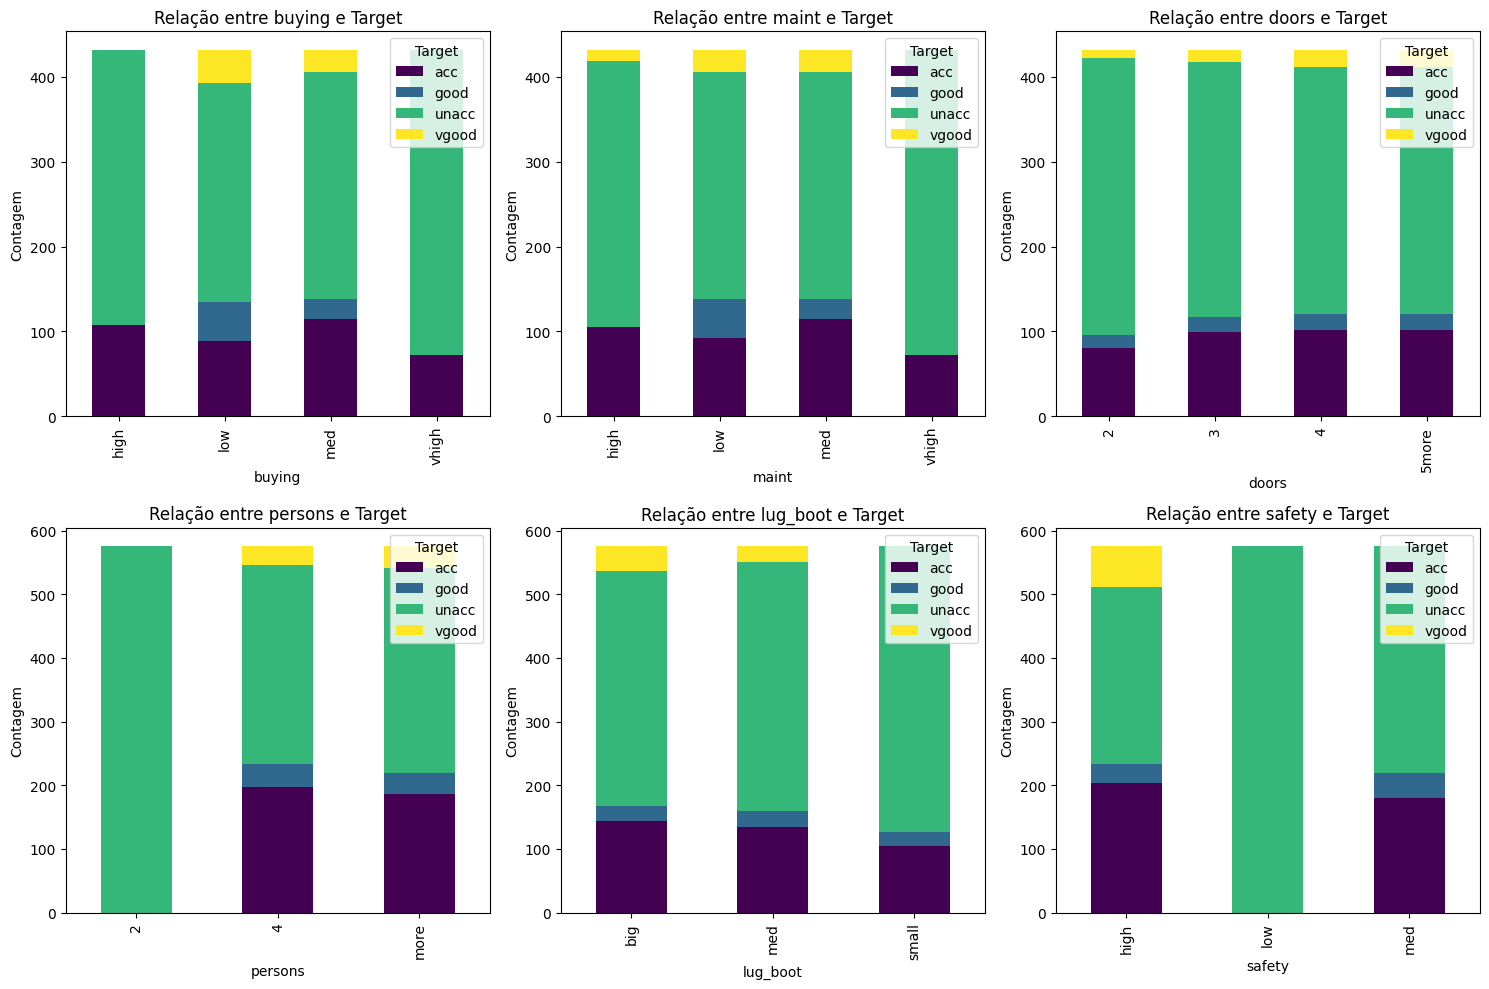

In [5]:
# Lista de variáveis categóricas
categorical_variables = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

# Configurar subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Iterar sobre as variáveis categóricas e os subplots
for variable, ax in zip(categorical_variables, axes.flatten()):
    # Tabela de contingência
    contingency_table = pd.crosstab(df[variable], df['target'])

    # Plotar gráfico de barras empilhadas
    contingency_table.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)

    ax.set_title(f'Relação entre {variable} e Target')
    ax.set_xlabel(variable)
    ax.set_ylabel('Contagem')
    ax.legend(title='Target', loc='upper right')

# Ajustar layout
plt.tight_layout()
plt.show()

In [6]:
# Codifique variáveis categóricas usando one-hot encoding
X_encoded = pd.get_dummies(X)

# Separe os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Substitua RandomForestClassifier pelo seu modelo
model = RandomForestClassifier()

# Inicialize a RFE com o modelo e o número de características desejadas
rfe = RFE(model, n_features_to_select=1)

# Ajuste a RFE ao conjunto de treinamento
X_rfe = rfe.fit_transform(X_train, y_train)

# Associe as classificações às colunas do DataFrame
feature_ranks_df = pd.DataFrame({'Feature': X_train.columns, 'Ranking': rfe.ranking_})

# Ordene as características pelos rankings
feature_ranks_df = feature_ranks_df.sort_values(by='Ranking')

# Exiba ou salve as características principais
print(feature_ranks_df)

           Feature  Ranking
19      safety_low        1
12       persons_2        2
18     safety_high        3
7      maint_vhigh        4
0      buying_high        5
3     buying_vhigh        6
17  lug_boot_small        7
4       maint_high        8
1       buying_low        9
20      safety_med       10
13       persons_4       11
14    persons_more       12
8          doors_2       13
15    lug_boot_big       14
5        maint_low       15
2       buying_med       16
6        maint_med       17
16    lug_boot_med       18
11     doors_5more       19
10         doors_4       20
9          doors_3       21


In [7]:
# Estatísticas descritivas para atributos numéricos
print(df.describe())

# Contagem de frequência para atributos categóricos
for column in df.columns:
    print(f'\n{column}:\n{df[column].value_counts()}')

       buying maint doors persons lug_boot safety target
count    1728  1728  1728    1728     1728   1728   1728
unique      4     4     4       3        3      3      4
top      high  high     2       2      big   high  unacc
freq      432   432   432     576      576    576   1210

buying:
buying
high     432
low      432
med      432
vhigh    432
Name: count, dtype: int64

maint:
maint
high     432
low      432
med      432
vhigh    432
Name: count, dtype: int64

doors:
doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64

persons:
persons
2       576
4       576
more    576
Name: count, dtype: int64

lug_boot:
lug_boot
big      576
med      576
small    576
Name: count, dtype: int64

safety:
safety
high    576
low     576
med     576
Name: count, dtype: int64

target:
target
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


<h2>Dados desbalanceados:</h2>

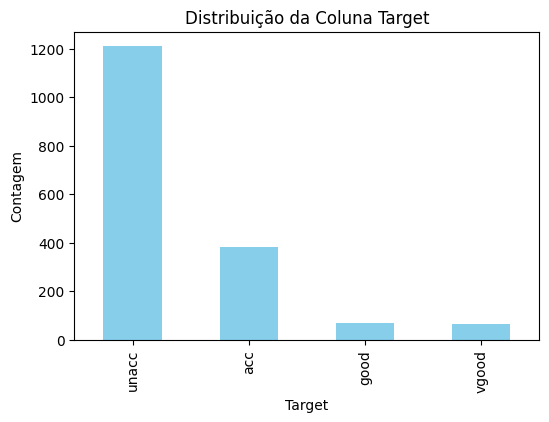

In [8]:
plt.figure(figsize=(6, 4))
df['target'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribuição da Coluna Target')
plt.xlabel('Target')
plt.ylabel('Contagem')
plt.show()

<p>Precisa de balanceamento pois há muitas classes unacceptable e acceptable</p>

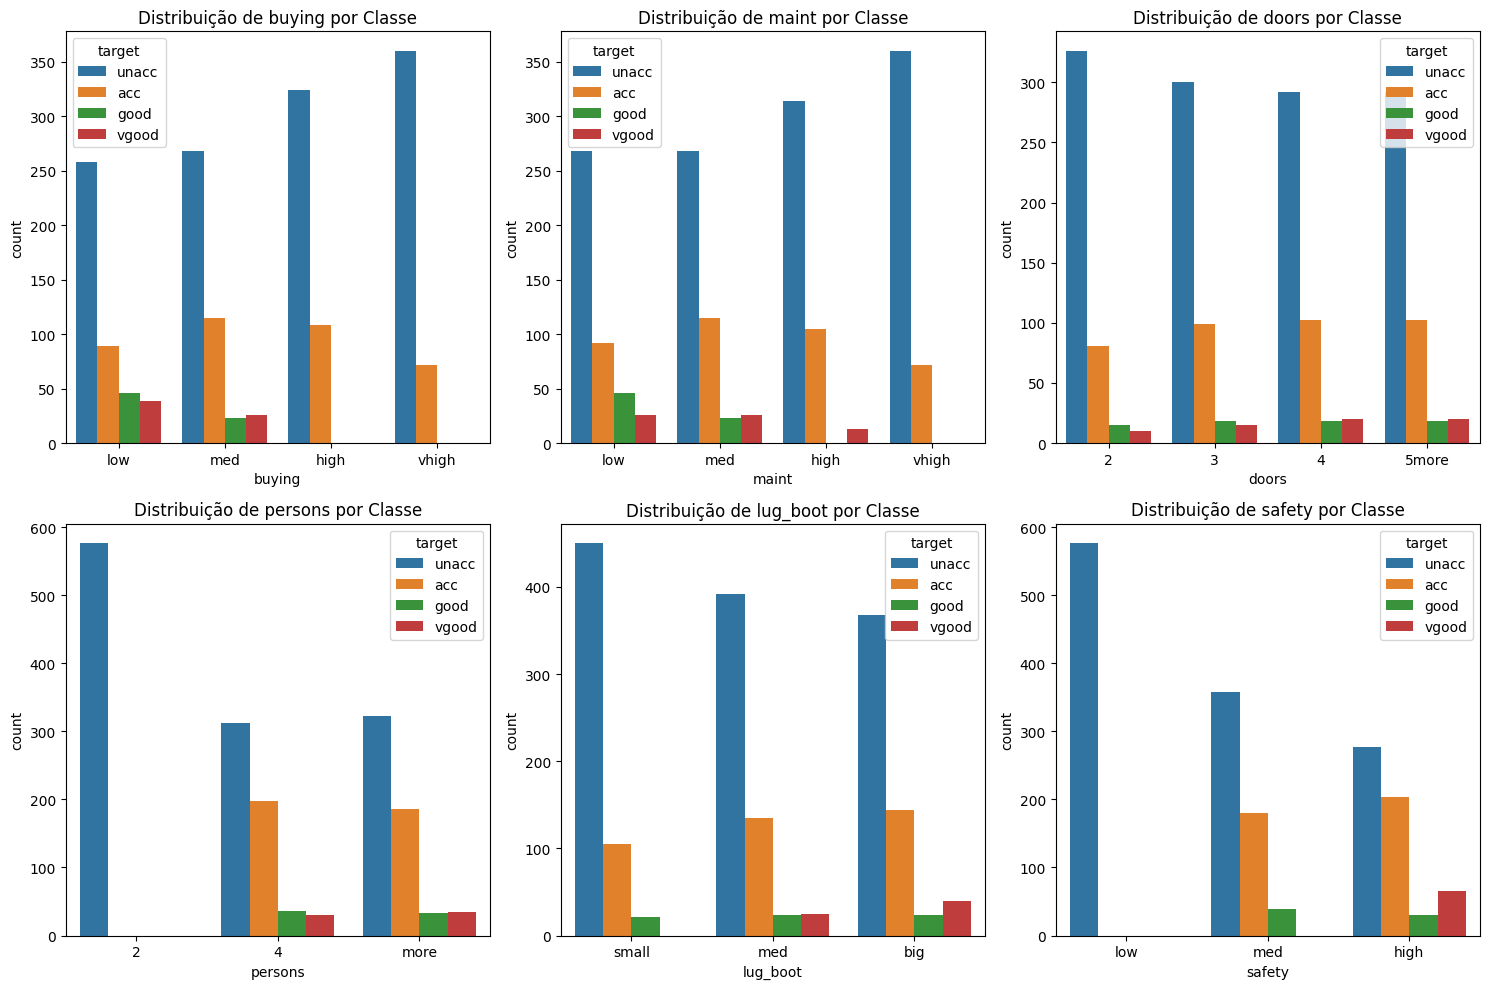

In [9]:
df['target'] = df['target'].cat.reorder_categories(['unacc', 'acc', 'good', 'vgood'], ordered=True)
df['buying'] = df['buying'].cat.reorder_categories(['low', 'med', 'high', 'vhigh'], ordered=True)
df['maint'] = df['maint'].cat.reorder_categories(['low', 'med', 'high', 'vhigh'], ordered=True)
df['lug_boot'] = df['lug_boot'].cat.reorder_categories(['small', 'med', 'big'], ordered=True)
df['safety'] = df['safety'].cat.reorder_categories(['low', 'med', 'high'], ordered=True)

plt.figure(figsize=(15, 10))

categorical_variables = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

for i, var in enumerate(categorical_variables, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=var, hue='target', data=df)
    plt.title(f'Distribuição de {var} por Classe')

plt.tight_layout()
plt.show()


<h3>Balanceamento por Undersampling</h3>

In [10]:
df_majority_unacc = df[df['target'] == 'unacc']
df_minority_acc = df[df['target'] == 'acc']
df_minority_good = df[df['target'] == 'good']
df_minority_vgood = df[df['target'] == 'vgood']

undersample_size = min(len(df_minority_acc), len(df_minority_good), len(df_minority_vgood))

# Ajuste a taxa de subamostragem para a classe 'ACC'
undersample_size_acc = 200  # Ajuste conforme necessário
df_majority_unacc_undersampled = resample(df_majority_unacc, replace=False, n_samples=undersample_size, random_state=42)
df_minority_acc_undersampled = resample(df_minority_acc, replace=False, n_samples=undersample_size_acc, random_state=42)

# Combine as classes majoritárias subamostradas com as classes minoritárias
df_balanced_undersampled = pd.concat([df_majority_unacc_undersampled, df_minority_acc_undersampled, df_minority_good, df_minority_vgood])

# Embaralhe novamente o DataFrame
df_balanced_undersampled = df_balanced_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
class_counts_undersampled = df_balanced_undersampled['target'].value_counts()

print("Contagem de instâncias por classe após o undersampling:")
print(class_counts_undersampled)

Contagem de instâncias por classe após o undersampling:
target
acc      200
good      69
unacc     65
vgood     65
Name: count, dtype: int64


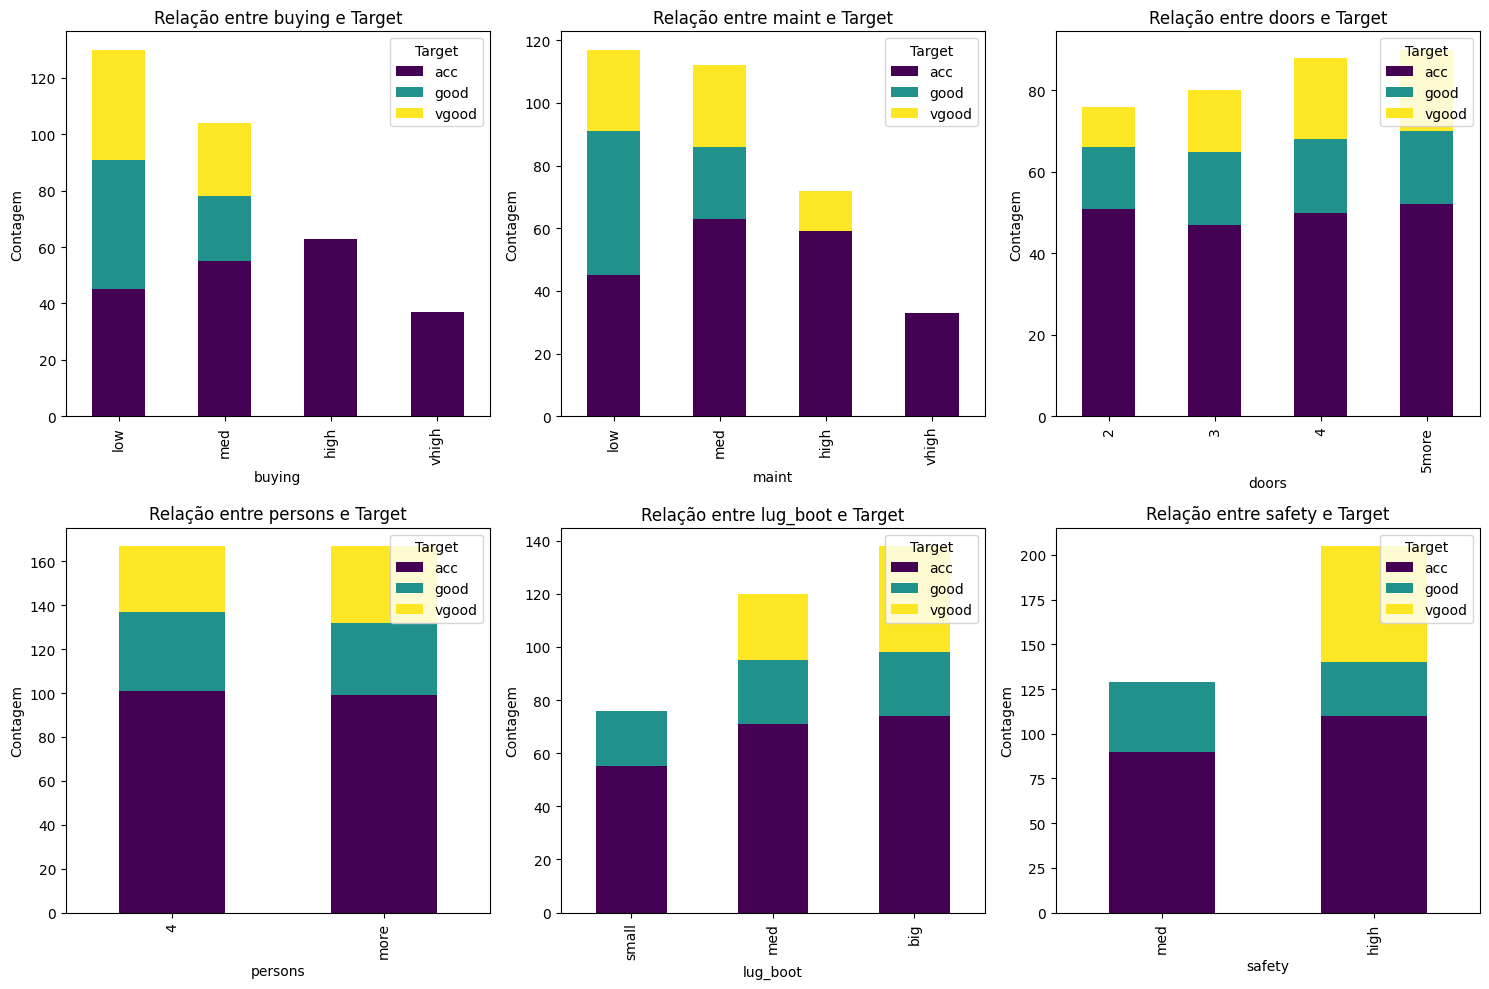

In [12]:
# Filtrar DataFrame para excluir a classe 'unacc'
df_filtered = df_balanced_undersampled[df_balanced_undersampled['target'] != 'unacc']

# Lista de variáveis categóricas
categorical_variables = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

# Configurar subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Iterar sobre as variáveis categóricas e os subplots
for variable, ax in zip(categorical_variables, axes.flatten()):
    # Tabela de contingência
    contingency_table = pd.crosstab(df_filtered[variable], df_filtered['target'])

    # Plotar gráfico de barras empilhadas
    contingency_table.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)

    ax.set_title(f'Relação entre {variable} e Target')
    ax.set_xlabel(variable)
    ax.set_ylabel('Contagem')
    ax.legend(title='Target', loc='upper right')

# Ajustar layout
plt.tight_layout()
plt.show()

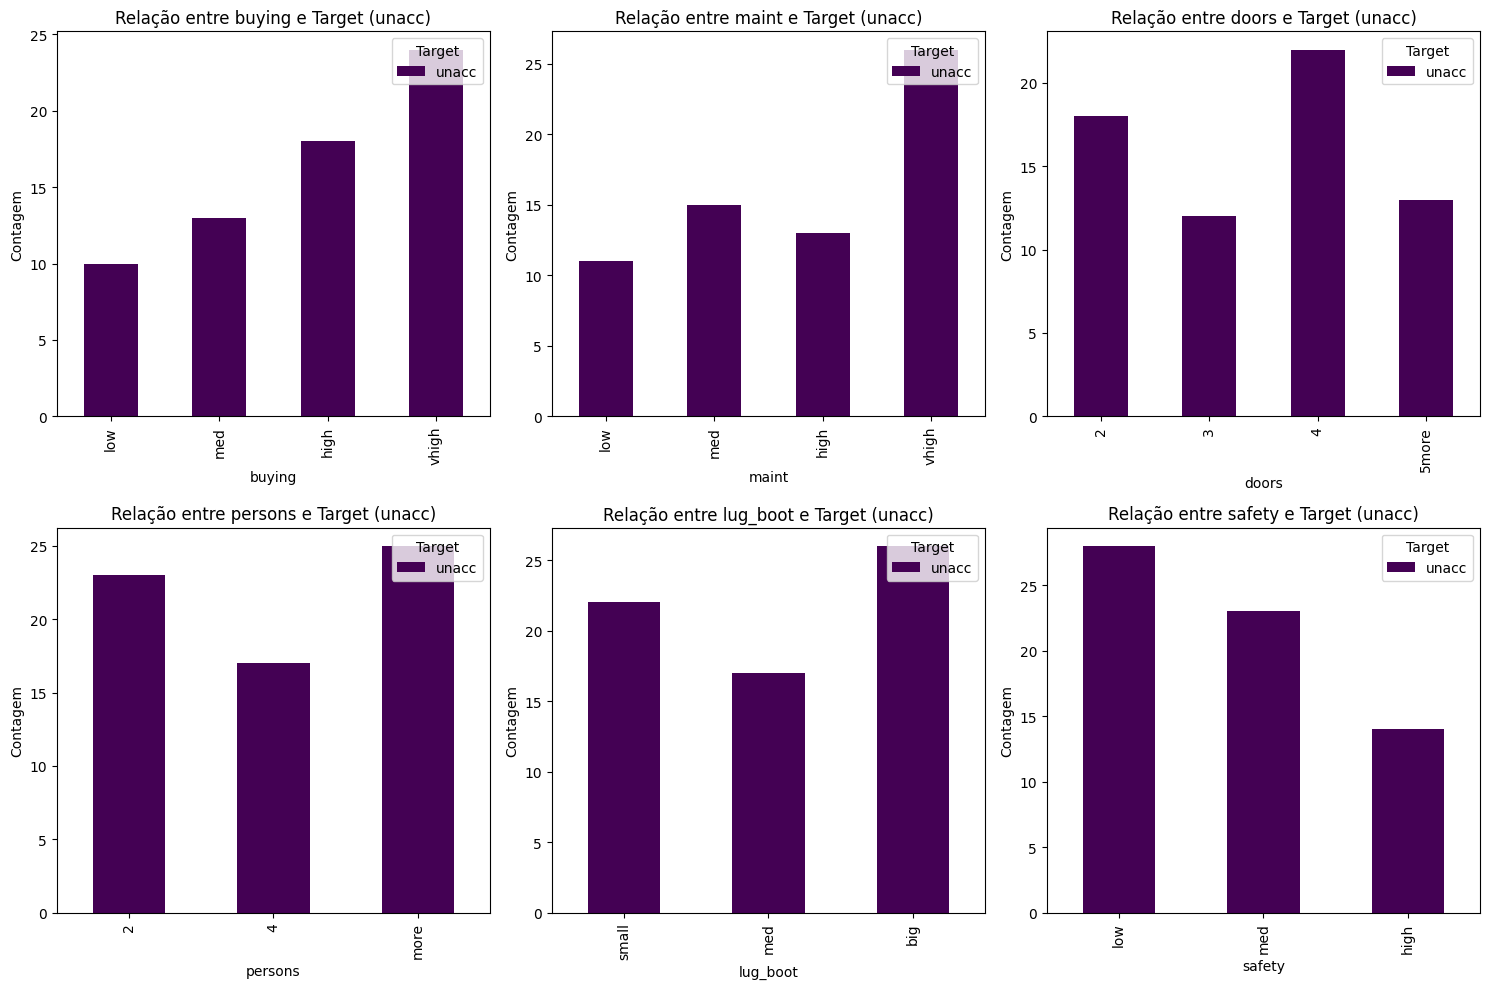

In [13]:
# Filtrar DataFrame para incluir apenas a classe 'unacc'
df_unacc = df_balanced_undersampled[df_balanced_undersampled['target'] == 'unacc']

# Configurar subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Iterar sobre as variáveis categóricas e os subplots
for variable, ax in zip(categorical_variables, axes.flatten()):
    # Tabela de contingência
    contingency_table = pd.crosstab(df_unacc[variable], df_unacc['target'])

    # Plotar gráfico de barras empilhadas
    contingency_table.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)

    ax.set_title(f'Relação entre {variable} e Target (unacc)')
    ax.set_xlabel(variable)
    ax.set_ylabel('Contagem')
    ax.legend(title='Target', loc='upper right')

# Ajustar layout
plt.tight_layout()
plt.show()


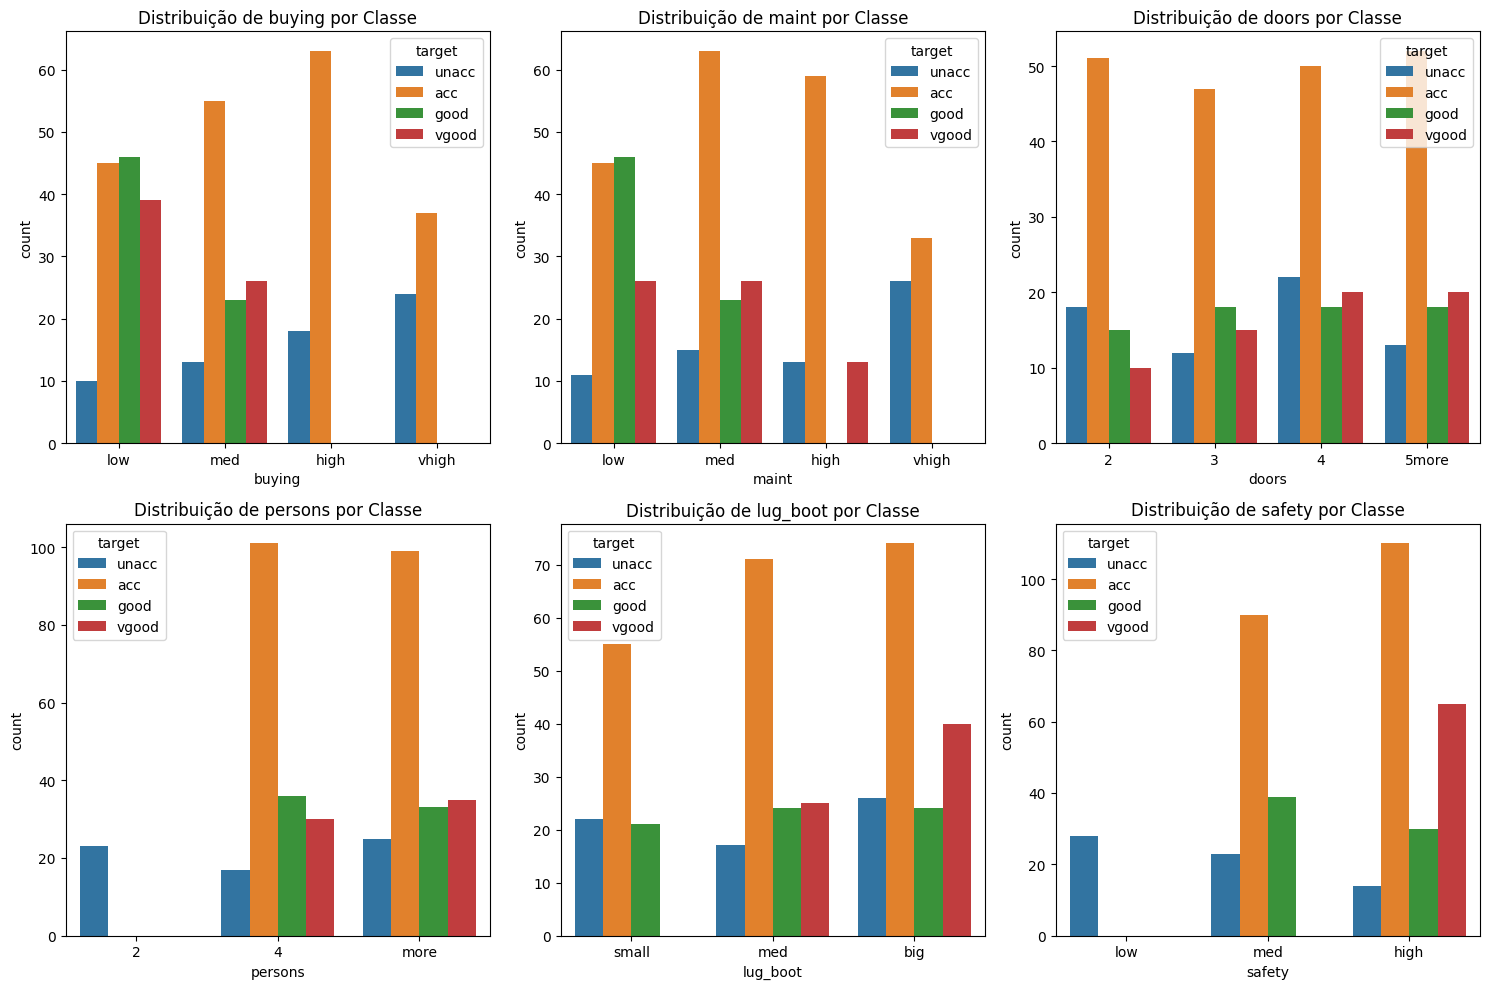

In [14]:
df_balanced_undersampled['target'] = df_balanced_undersampled['target'].cat.reorder_categories(['unacc', 'acc', 'good', 'vgood'], ordered=True)
df_balanced_undersampled['buying'] = df_balanced_undersampled['buying'].cat.reorder_categories(['low', 'med', 'high', 'vhigh'], ordered=True)
df_balanced_undersampled['maint'] = df_balanced_undersampled['maint'].cat.reorder_categories(['low', 'med', 'high', 'vhigh'], ordered=True)
df_balanced_undersampled['lug_boot'] = df_balanced_undersampled['lug_boot'].cat.reorder_categories(['small', 'med', 'big'], ordered=True)
df_balanced_undersampled['safety'] = df_balanced_undersampled['safety'].cat.reorder_categories(['low', 'med', 'high'], ordered=True)

plt.figure(figsize=(15, 10))

categorical_variables = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']

for i, var in enumerate(categorical_variables, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=var, hue='target', data=df_balanced_undersampled)
    plt.title(f'Distribuição de {var} por Classe')

plt.tight_layout()
plt.show()


<h2>Random Forest</h2>

In [15]:
X = df_balanced_undersampled.drop('target', axis=1)
y = df_balanced_undersampled['target']

# Codificação one-hot para variáveis categóricas
X_encoded = pd.get_dummies(X)

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Inicializar o modelo Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Treinar o modelo
rf_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
predictions_rf = rf_classifier.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, predictions_rf)
print(f'Acurácia: {accuracy:.4f}%')

print('\nRelatório de Classificação:')
print(classification_report(y_test, predictions_rf))

conf_matrix = confusion_matrix(y_test, predictions_rf)
print('\nMatriz de Confusão:')
print(conf_matrix)

Acurácia: 0.9250%

Relatório de Classificação:
              precision    recall  f1-score   support

         acc       0.95      0.95      0.95        41
        good       0.79      1.00      0.88        11
       unacc       1.00      0.77      0.87        13
       vgood       0.93      0.93      0.93        15

    accuracy                           0.93        80
   macro avg       0.92      0.91      0.91        80
weighted avg       0.93      0.93      0.92        80


Matriz de Confusão:
[[39  2  0  0]
 [ 0 11  0  0]
 [ 2  0 10  1]
 [ 0  1  0 14]]


<h2>SVM</h2>

In [16]:
X = df_balanced_undersampled.drop('target', axis=1)
y = df_balanced_undersampled['target']
X_encoded = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
svm_classifier = SVC(random_state=42)

svm_classifier.fit(X_train, y_train)

predictions_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, predictions_svm)
print(f'Acurácia do SVM: {accuracy_svm:.4f}%')

print('\nRelatório de Classificação do SVM:')
print(classification_report(y_test, predictions_svm))

conf_matrix_svm = confusion_matrix(y_test, predictions_svm)
print('\nMatriz de Confusão do SVM:')
print(conf_matrix_svm)

Acurácia do SVM: 0.9500%

Relatório de Classificação do SVM:
              precision    recall  f1-score   support

         acc       0.97      0.95      0.96        41
        good       0.85      1.00      0.92        11
       unacc       1.00      0.85      0.92        13
       vgood       0.94      1.00      0.97        15

    accuracy                           0.95        80
   macro avg       0.94      0.95      0.94        80
weighted avg       0.95      0.95      0.95        80


Matriz de Confusão do SVM:
[[39  2  0  0]
 [ 0 11  0  0]
 [ 1  0 11  1]
 [ 0  0  0 15]]


<h2>Balanceamento com Oversampling</h2>


In [17]:
car_evaluation = fetch_openml(name="car", version=3, parser='auto')
df = pd.DataFrame(data=car_evaluation.data, columns=car_evaluation.feature_names)
df['target'] = car_evaluation.target

X = df.drop('target', axis=1)
y = df['target']
X_encoded = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [18]:
df_oversampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)
class_counts_oversampled = df_oversampled['target'].value_counts()

print("Contagem de instâncias por classe após o undersampling:")
print(class_counts_oversampled)

Contagem de instâncias por classe após o undersampling:
target
acc      975
good     975
unacc    975
vgood    975
Name: count, dtype: int64


<h2>Random Forest</h2>

In [19]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

predictions_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, predictions_rf)
print(f'Acurácia do Random Forest com oversampling: {accuracy_rf:.4f}%')

print('\nRelatório de Classificação do Random Forest com oversampling:')
print(classification_report(y_test, predictions_rf))

conf_matrix_rf = confusion_matrix(y_test, predictions_rf)
print('\nMatriz de Confusão do Random Forest com oversampling:')
print(conf_matrix_rf)

Acurácia do Random Forest com oversampling: 0.9653%

Relatório de Classificação do Random Forest com oversampling:
              precision    recall  f1-score   support

         acc       0.99      0.88      0.93        83
        good       0.59      0.91      0.71        11
       unacc       1.00      1.00      1.00       235
       vgood       0.84      0.94      0.89        17

    accuracy                           0.97       346
   macro avg       0.85      0.93      0.88       346
weighted avg       0.97      0.97      0.97       346


Matriz de Confusão do Random Forest com oversampling:
[[ 73   7   1   2]
 [  0  10   0   1]
 [  0   0 235   0]
 [  1   0   0  16]]


<h2>SVM</h2>

In [20]:
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train_resampled, y_train_resampled)

predictions_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, predictions_svm)
print(f'Acurácia do SVM com oversampling: {accuracy_svm:.4f}%')

print('\nRelatório de Classificação do SVM com oversampling:')
print(classification_report(y_test, predictions_svm))

conf_matrix_svm = confusion_matrix(y_test, predictions_svm)
print('\nMatriz de Confusão do SVM com oversampling:')
print(conf_matrix_svm)

Acurácia do SVM com oversampling: 0.9740%

Relatório de Classificação do SVM com oversampling:
              precision    recall  f1-score   support

         acc       0.99      0.92      0.95        83
        good       0.59      0.91      0.71        11
       unacc       1.00      1.00      1.00       235
       vgood       0.94      0.94      0.94        17

    accuracy                           0.97       346
   macro avg       0.88      0.94      0.90       346
weighted avg       0.98      0.97      0.98       346


Matriz de Confusão do SVM com oversampling:
[[ 76   7   0   0]
 [  0  10   0   1]
 [  0   0 235   0]
 [  1   0   0  16]]
